In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import linregress

In [170]:
RED="\033[1;91m"
RESET="\033[0m"

In [171]:
df_test_measure=pd.read_csv("test_measure.csv")
df_subject_info=pd.read_csv("subject-info.csv")
df_test_measure_No_Duplicates=df_test_measure.drop_duplicates()
df_merged=pd.merge(df_subject_info, df_test_measure,on=['ID_test','ID'],how='left')
df_merged_No_Duplicates=df_merged.drop_duplicates()

## 1.Which athletes demonstrate the highest oxygen uptake efficiency (VO₂ per unit of work or speed)?

In [172]:
#Filter out rows where speed is 0 or VO2 is 0 to avoid division errors

valid_data=df_merged_No_Duplicates[(df_merged_No_Duplicates['Speed']>0)&(df_merged_No_Duplicates['VO2']>0)].copy()

#Calculate VO2 efficiency as VO2 per unit speed

valid_data['VO2_per_speed']=valid_data['VO2']/valid_data['Speed']

#Average VO2 efficiency for each athlete

efficiency_per_athlete=valid_data.groupby('ID')['VO2_per_speed'].mean().reset_index()

#Sort by efficiency(lower is better)

most_efficient_athletes=efficiency_per_athlete.sort_values(by='VO2_per_speed')

#Show top 10 most efficient

print("Top 10 athletes with highest oxygen uptake efficiency (lowest VO₂ per speed):\n")
print(most_efficient_athletes.head(10).to_string(index=False))


Top 10 athletes with highest oxygen uptake efficiency (lowest VO₂ per speed):

 ID  VO2_per_speed
539     103.343379
557     131.789671
577     133.718678
140     139.629945
349     141.522464
 51     142.024675
828     148.051069
602     148.858490
 11     156.673956
795     157.598066


###### Insight:
This gives us an idea of how efficiently an athlete uses oxygen at a given treadmill speed - the higher the ratio, the less efficient they are (using more oxygen per unit of speed), so we'll actually be interested in lower values for better efficiency (or you can invert it and use Speed / VO2 to indicate efficiency directly).

## 2.Can we create an index combining VO2 max and HR to estimate cardiovascular endurance?

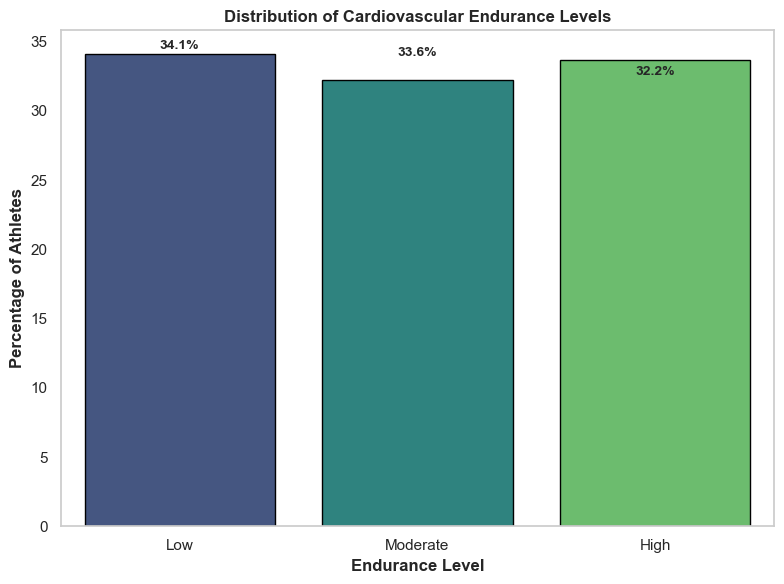

In [173]:
# Calculate VO2 max per athlete (normalized by weight)
df_merged_No_Duplicates['VO2_Max_per_kg']=df_merged_No_Duplicates['VO2']/df_merged_No_Duplicates['Weight']

# Get max VO2 per athlete
vo2_max=df_merged_No_Duplicates.groupby('ID')['VO2_Max_per_kg'].max().reset_index(name='VO2_max')

# Get resting HR (Speed==0)
resting_hr=df_merged_No_Duplicates[df_merged_No_Duplicates['Speed']==0]
resting_hr=resting_hr.groupby('ID')['HR'].min().reset_index(name='Resting_HR')

# Merge (cardiovascular endurance(CEI))
CEI_df=pd.merge(vo2_max,resting_hr,on='ID')

# Step 5: Calculate Cardiovascular Endurance Index (CEI)
CEI_df['CEI']=(CEI_df['VO2_max']/CEI_df['Resting_HR']).round(2)

# Step 6: Sort by CEI
CEI_df_sorted=CEI_df.sort_values(by='CEI',ascending=False)

# Step 7: Categorize into Endurance Levels using percentiles
CEI_df_sorted['Endurance_Level']=pd.qcut(
    CEI_df_sorted['CEI'],
    q=[0, 0.33, 0.66, 1],
    labels=['Low', 'Moderate', 'High']
)

# Calculate the percentage of athletes in each endurance level
endurance_counts=CEI_df_sorted['Endurance_Level'].value_counts(normalize=True)*100

#Plot
plt.figure(figsize=(8,6))
ax=sns.barplot(x=endurance_counts.index, y=endurance_counts.values,palette='viridis',edgecolor='black')

# Add percentage labels
for i,val in enumerate(endurance_counts.values):
    ax.text(i,val+1,f'{val:.1f}%',ha='center',va='top',fontsize=10,fontweight='bold')
plt.grid(False)
plt.title('Distribution of Cardiovascular Endurance Levels',fontweight='bold')
plt.xlabel('Endurance Level',fontweight='bold')
plt.ylabel('Percentage of Athletes',fontweight='bold')
plt.tight_layout()
plt.show()


###### Insight:

Higher VO2 max = better endurance

Lower resting HR = more efficient heart (better endurance)

## 3. Recovery Rate:How quickly does each athlete's heart rate drop after peak speed for each test?


Logic:Find HR at peak speed, then track drop over next 2–3 time points.

In [174]:
#Sort the DataFrame by ID_test and time
df_sorted=df_merged_No_Duplicates.sort_values(by=['ID_test','time']).reset_index(drop=True)

# Find index of peak speed for each test
peak_idx=df_sorted.groupby('ID_test')['Speed'].idxmax()

# Initialize list for recovery info
recovery_data=[]

# Loop through each test's peak speed index
for idx in peak_idx:
    row=df_sorted.loc[idx]
    test_id=row['ID_test']
    hr_peak=row['HR']

    # Get next 3 rows
    next_rows=df_sorted.iloc[idx+1:idx+4]
    next_hr=next_rows[next_rows['ID_test']==test_id]['HR']

    if not next_hr.empty:
        avg_next_hr=next_hr.mean()
        recovery_rate=hr_peak-avg_next_hr
    else:
        avg_next_hr=None
        recovery_rate=None

    recovery_data.append({
        'ID_test':test_id,
        'HR_at_Peak':hr_peak,
        'Avg_HR_Next3':avg_next_hr,
        'Recovery_Rate':recovery_rate
    })

recovery_df=pd.DataFrame(recovery_data)

print('Heart Rate Recovery after Peak Speed:\n')
print(recovery_df.sort_values(by='Recovery_Rate',ascending=False).head(10).to_string(index=False))


Heart Rate Recovery after Peak Speed:

ID_test  HR_at_Peak  Avg_HR_Next3  Recovery_Rate
  538_1       163.0    128.000000      35.000000
  391_1       193.0    158.666667      34.333333
  365_1       170.0    145.666667      24.333333
   29_1       184.0    161.666667      22.333333
 526_55       188.0    167.333333      20.666667
  444_1       172.0    153.000000      19.000000
  786_1       196.0    177.000000      19.000000
  473_1       111.0     95.666667      15.333333
  589_1       205.0    191.666667      13.333333
   52_1       188.0    176.333333      11.666667


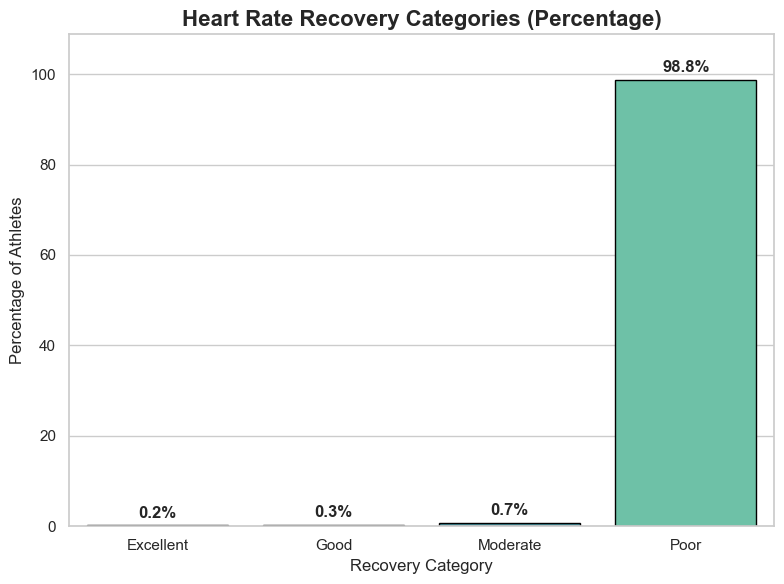

In [23]:
def categorize_recovery(rate):
    if rate>=30:
        return 'Excellent'
    elif rate>=20:
        return 'Good'
    elif rate>=10:
        return 'Moderate'
    else:
        return 'Poor'

recovery_df['Recovery_Category']=recovery_df['Recovery_Rate'].apply(categorize_recovery)

category_counts=recovery_df['Recovery_Category'].value_counts(normalize=True)*100
category_counts=category_counts.reindex(['Excellent','Good','Moderate','Poor']).fillna(0)

sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8,6))
ax=sns.barplot(x=category_counts.index,y=category_counts.values,palette="mako",edgecolor='black')

# Add percentage labels
for i,val in enumerate(category_counts.values):
    ax.text(i,val+1,f'{val:.1f}%',ha='center',va='bottom',fontweight='bold',fontsize=12)

# Titles and axis labels
plt.title('Heart Rate Recovery Categories (Percentage)',fontsize=16,fontweight='bold')
plt.xlabel('Recovery Category',fontsize=12)
plt.ylabel('Percentage of Athletes',fontsize=12)
plt.ylim(0,max(category_counts.values)+10)  # give room for labels
plt.tight_layout()
plt.show()


###### Insight:
Based on the dataset, the majority of athletes fall into the Poor recovery rate category, followed by Moderate, then Good, with the fewest athletes demonstrating an Excellent recovery rate.

## 4.How many athletes experienced tachypnea (high respiratory rate) during rest?

In [175]:
# Filter for rest period and tachypnea (Respiration>20)

tachypnea_rest=df_merged[(df_merged['Speed']==0)&(df_merged['RR']>20)]

# Count unique athletes who experienced tachypnea at rest
tachypnea_athletes=tachypnea_rest['ID'].nunique()

print(f'Number of athletes who experienced tachypnea during rest: {RED}{tachypnea_athletes}{RESET}')


Number of athletes who experienced tachypnea during rest: 139


## 5.Can we estimate the maximum calories burned during a test for each athlete??

In [176]:
# Formula to estimate calories burned:
# kcal = VO2 (mL/kg/min) × body weight (kg)/ 1000 × 5

df_merged['Calories_Burned']=(df_merged['VO2']*df_merged['Weight'])/1000*5
max_calories_per_test = df_merged.groupby('ID_test')['Calories_Burned'].max().reset_index()
max_calories_per_test = calories_per_test.sort_values(by='Calories_Burned', ascending=False)
max_calories_per_test.head(10)

,ID_test,Calories_Burned
881,783_1,3723.975
629,575_1,2918.960
394,409_1,2673.310
208,266_1,2638.860
78,15_27,2567.850
626,572_1,2491.445
209,267_1,2462.500
762,683_1,2457.350
120,192_1,2454.750
431,438_1,2420.620


###### Insight:
By using this method, we can identify the tests where athletes burned the most calories, which may provide insights into the intensity and duration of the tests that led to higher energy expenditure.

## 6. Radar Chart per Athlete
Compare HR, VO2, VCO2, RR in one radar plot to compare fitness profiles.

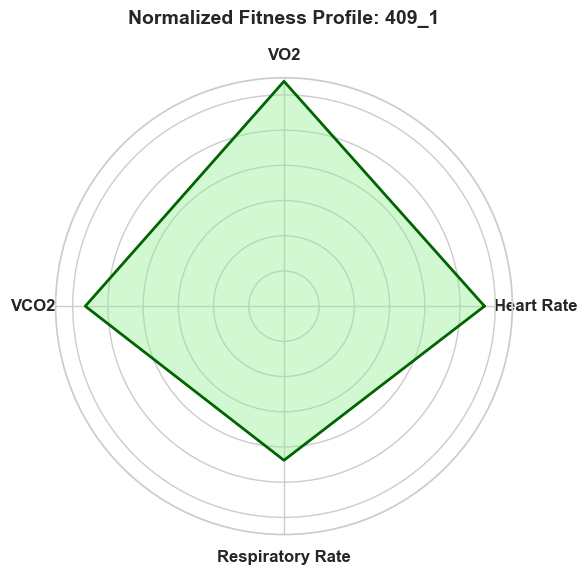

In [177]:
def plot_normalized_radar_chart(df,id_test,features,labels,title):
    # Ensure numeric and drop missing
    df[features] = df[features].apply(pd.to_numeric,errors='coerce')
    df = df.dropna(subset=features)

    # Filter by ID_test
    df_selected=df[df['ID_test']==id_test]
    if df_selected.empty:
        print(f"No data for {id_test}")
        return

    # Get mean values for selected test
    raw_values=df_selected[features].mean().values

    # Normalize using min-max across full dataset (per feature)
    min_vals=df[features].min().values
    max_vals=df[features].max().values
    norm_values=(raw_values-min_vals)/(max_vals-min_vals)

    # Close the radar chart loop
    norm_values=norm_values.tolist()
    norm_values+=norm_values[:1]

    # Now match angles to that
    angles=np.linspace(0,2*np.pi,len(features),endpoint=False).tolist()
    angles+=angles[:1]

    # Plot
    fig,ax=plt.subplots(figsize=(6,6),subplot_kw=dict(polar=True))
    ax.plot(angles,norm_values,color='darkgreen',linewidth=2)
    ax.fill(angles,norm_values,color='lightgreen',alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax.set_yticklabels([])
    ax.set_title(title, fontsize=14, fontweight='bold', y=1.1)

    plt.tight_layout()
    plt.show()

#Usage example
features = ['HR', 'VO2', 'VCO2', 'RR']
labels = ['Heart Rate', 'VO2', 'VCO2', 'Respiratory Rate']
id_test = '409_1'

plot_normalized_radar_chart(df_merged, id_test, features, labels, f'Normalized Fitness Profile: {id_test}')


HR (Heart Rate): If HR is positioned closer to the center, it suggests the athlete has a higher heart rate at a given intensity, which could indicate that they are less fit, as higher heart rates at lower intensities are typically associated with lower cardiovascular efficiency.

VO2 (Oxygen Consumption): VO2 is a key indicator of aerobic capacity. A larger value will be positioned farther from the center, indicating better aerobic fitness. Compare how well this is performing relative to other athletes.

VCO2 (Carbon Dioxide Production): Like VO2, this value provides insight into the athlete's metabolism. If VCO2 is low compared to VO2, the athlete may be in a more efficient aerobic state, while higher VCO2 may suggest anaerobic pathways are more active.

RR (Respiratory Rate): This indicates the athlete's breathing rate. A higher RR, especially when coupled with a higher HR, might indicate more intense activity, or an athlete who is less efficient at breathing. Alternatively, a lower RR could indicate a more controlled and efficient respiratory system.

## Insight:
This athlete appears to be aerobically fit (since VO2 is high), but they may not be pushing themselves to the maximal anaerobic threshold, as indicated by the lower VCO2. Their cardiovascular system (HR) and respiratory system (RR) are working relatively efficiently, with HR and VCO2 showing similar patterns. This indicates that the athlete's body is effectively coordinating their heart rate and metabolic processes during exercise.

## 7. BMI vs VO2 Scatter Plot
Investigate how BMI affects VO2 uptake.

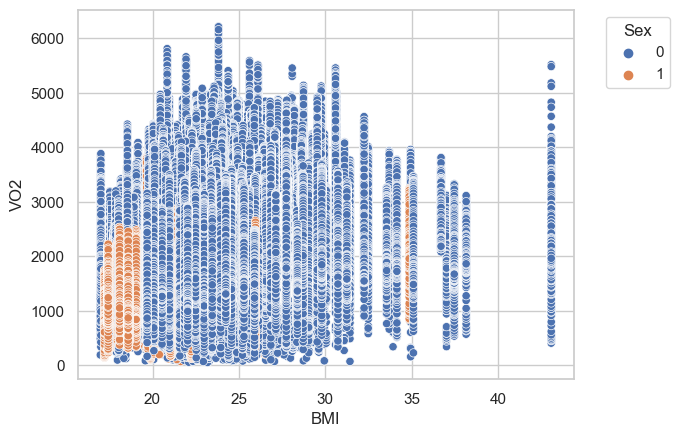

In [178]:
df_merged_No_Duplicates['Height_meters']=df_merged_No_Duplicates['Height']/100
df_merged_No_Duplicates['BMI']=df_merged_No_Duplicates['Weight']/(df_merged_No_Duplicates['Height_meters']**2)

sns.scatterplot(data=df_merged_No_Duplicates,x='BMI',y='VO2',hue='Sex')
plt.legend(title='Sex',bbox_to_anchor=(1.05,1));


## 8.Find participants whose info varies between tests and show participant list.

In [180]:
# Check if values are inconsistent across tests for each participant
variation=df_merged.groupby('ID')[['Age','Height','Weight']].nunique().reset_index()
variation['Varies']=variation[['Age','Height','Weight']].max(axis=1)>1

# IDs with variation
inconsistent_ids=variation[variation['Varies']==True]['ID']

print(f'participants whose info varies between tests are: {RED}{inconsistent_ids.shape[0]}{RESET}\n')

print(inconsistent_data.head(10).to_string(index=False))

participants whose info varies between tests are: 114

 Age  Weight  Height  Humidity  Temperature  Sex  ID ID_test
13.7    53.8   169.7      40.0         25.3    0 341   341_1
13.8    53.4   171.0      42.0         24.4    0 341   341_2
14.0    46.0   160.0      40.0         25.3    0 343   343_1
14.1    49.7   160.1      40.0         25.8    0 339   339_1
14.1    46.6   161.5      41.0         26.5    0 343   343_5
14.2    65.2   170.1      42.0         24.4    0 333   333_1
14.2    51.0   163.0      42.0         24.4    0 339   339_5
14.3    54.3   168.5      44.0         25.4    0 331   331_1
14.3    66.1   172.0      42.0         24.4    0 333   333_7
14.4    51.4   169.5      52.0         23.8    0 132   132_1


## 10. Track HR and VO2 over time and detect anomalies or sudden peaks.

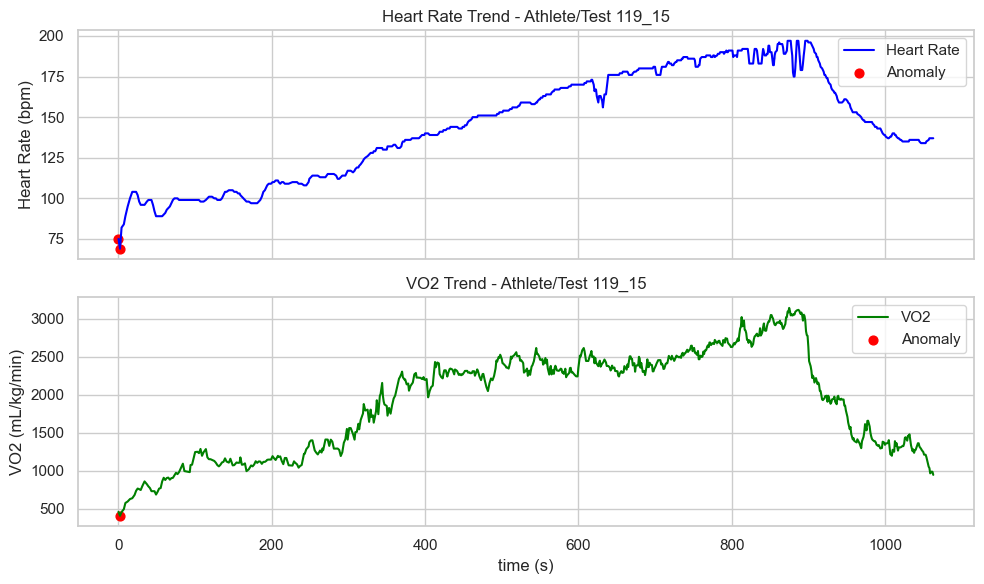

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

#Select one athlete/test to analyze
example_id = '119_15'  # Replace with a valid ID_test from your dataset
df_time=df_merged[df_merged['ID_test']==example_id].copy()

#Sort by time (assuming 'Time' is in seconds or datetime)
df_time=df_time.sort_values(by='time')

#Detect anomalies using z-score (basic method)
df_time['HR_zscore']=zscore(df_time['HR'])
df_time['VO2_zscore']=zscore(df_time['VO2'])

# Threshold for anomaly detection
threshold=2.5
df_time['HR_anomaly']=df_time['HR_zscore'].abs()>threshold
df_time['VO2_anomaly']=df_time['VO2_zscore'].abs()>threshold

#Plot HR and VO2 with anomaly points
fig,ax=plt.subplots(2,1,figsize=(10,6),sharex=True)

# HR plot
sns.lineplot(data=df_time,x='time',y='HR',ax=ax[0],label='Heart Rate',color='blue')
ax[0].scatter(df_time[df_time['HR_anomaly']]['time'],df_time[df_time['HR_anomaly']]['HR'],
              color='red',label='Anomaly',s=40)
ax[0].set_title(f'Heart Rate Trend - Athlete/Test {example_id}')
ax[0].set_ylabel('Heart Rate (bpm)')
ax[0].legend()

# VO2 plot
sns.lineplot(data=df_time,x='time',y='VO2',ax=ax[1],label='VO2',color='green')
ax[1].scatter(df_time[df_time['VO2_anomaly']]['time'],df_time[df_time['VO2_anomaly']]['VO2'],
              color='red',label='Anomaly',s=40)
ax[1].set_title(f'VO2 Trend - Athlete/Test {example_id}')
ax[1].set_ylabel('VO2 (mL/kg/min)')
ax[1].set_xlabel('time (s)')
ax[1].legend()
plt.tight_layout()
plt.show()


## Insight:
For athlete test 119_15, both heart rate and VO₂ showed sudden spikes at the start of the session (0 seconds), likely due to sensor initialization or data recording artifacts. After the initial spike, both parameters followed a stable upward trend, reflecting a normal physiological response to increasing exercise intensity.

## 11. Create a metric that combines HR increase and VO2 flattening to detect early fatigue.

In [184]:
# Choose a test
test_id = '119_15'  # Replace with your ID_test
df_test = df_merged[df_merged['ID_test'] == test_id].copy()

#Sort by time
df_test = df_test.sort_values('time')

# Calculate linear regression slope for HR and VO2
hr_slope= linregress(df_test['time'], df_test['HR']).slope
vo2_slop = linregress(df_test['time'], df_test['VO2']).slope

# Define Fatigue Index
# Higher HR slope (rapid HR increase) and lower VO2 slope (flattening) indicate fatigue
fatigue_index=hr_slope/(vo2_slope+1e-5)

# Step 5: Output and Interpretation
print(f"Fatigue Index for {RED}{test_id} : {fatigue_index:.2f}{RESET}\n")

if fatigue_index>1.5:
    print("Insight: Athlete may be showing signs of early fatigue – sharp HR rise with flattening VO₂.")
elif 0.8<fatigue_index<=1.5:
    print(f"{RED}Insight:{RESET} Moderate fatigue – HR and VO₂ are increasing at comparable rates.")
else:
    print(f"{RED}Insight:{RESET} Efficient cardiovascular response – VO₂ increase matches HR rise.")


Fatigue Index for 119_15 : 0.07

Insight: Efficient cardiovascular response – VO₂ increase matches HR rise.
